# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')
print(len(train),len(test),len(submit))

891 418 418


#### Check for null data

In [3]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# can drop 2 nans in the embarked column
train = train[train['Embarked'].isna()!=True]

In [5]:
print(len(train),len(test))

889 418


In [6]:
train[train['Age'].isna()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


TODO:<br>
1) Only first class passengers can have a cabin, so cabin feature is not useful.
    However, the cabin letters could indicate what floor level each passenger is at. Cabin A is at the top, so it is closest to the deck where the lifeboats are. As a result, it could be useful to use Cabin letters. <br>

### Feature engineering

In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
train['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [9]:
train[(train['Parch']==0) & (train['Age'].isna()==True)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


Most of the nan values for age can be solved using Parch

In [10]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [11]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### "Some children travelled only with a nanny, therefore parch=0 for them" source kaggle variable notes

In [12]:
# Add column age range 
train['AgeRange'] = None
train.loc[train['Age']<13,'AgeRange'] = 'Child'
train.loc[(train['Age']>=13)&(train['Age']<21),'AgeRange'] = 'Teen'
train.loc[train['Age']>=21,'AgeRange'] = 'Adult'
train.loc[(train['Parch']==0)&(train['Age'].isna()==True),'AgeRange'] = 'Child'
train.loc[train['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'
# drop Age column
#train = train.drop(['Age'], axis=1) 
test['AgeRange'] = None
test.loc[test['Age']<13,'AgeRange'] = 'Child'
test.loc[(test['Age']>=13)&(test['Age']<21),'AgeRange'] = 'Teen'
test.loc[test['Age']>=21,'AgeRange'] = 'Adult'
test.loc[(test['Parch']==0)&(test['Age'].isna()==True),'AgeRange'] = 'Child'
test.loc[test['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'

In [13]:
dummies = pd.get_dummies(train.Sex)
train['Male'] = 0
train['Female'] = 0
train.loc[:,'Male'] =  dummies.male
train.loc[:,'Female'] =  dummies.female
#train = train.drop(['Sex'], axis=1) 
train.head()
dummies = pd.get_dummies(test.Sex)
test['Male'] = 0
test['Female'] = 0
test.loc[:,'Male'] =  dummies.male
test.loc[:,'Female'] =  dummies.female
#test = test.drop(['Sex'], axis=1) 

In [14]:
dummies = pd.get_dummies(train.AgeRange)
train['Child'] = 0
train['Adult'] = 0
train['Teen'] = 0
train['Teen_Adult'] = 0
train.loc[:,'Teen_Adult'] =  dummies.Teen_Adult
train.loc[:,'Adult'] =  dummies.Adult
train.loc[:,'Child'] =  dummies.Child
train.head()
dummies = pd.get_dummies(test.AgeRange)
test['Child'] = 0
test['Adult'] = 0
test['Teen'] = 0
test['Teen_Adult'] = 0
test.loc[:,'Teen_Adult'] =  dummies.Teen_Adult
test.loc[:,'Adult'] =  dummies.Adult
test.loc[:,'Child'] =  dummies.Child

### Feature Selection

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeRange', 'Male',
       'Female', 'Child', 'Adult', 'Teen', 'Teen_Adult'],
      dtype='object')

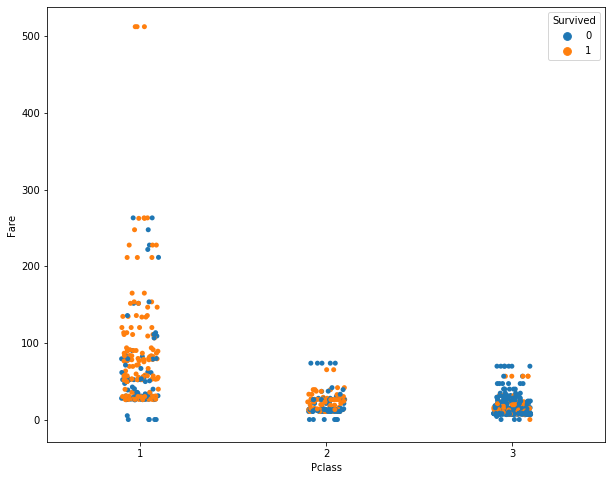

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
# check relation between fare price and Pclass
plt.figure(figsize=(10, 8))
sns.stripplot(x='Pclass',y='Fare',hue='Survived',data=train)
plt.show()

#### Observations:
1) Fare price does not relate to the ticket class. <br>
2) 1st and 2nd class ticket holders had a higher chance of survival <br>

## Model

In [17]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
features = ['Pclass','SibSp','Parch','Male','Female','Child','Adult','Teen','Teen_Adult']
X = train[features]
Y = train['Survived']
clf = clf.fit(X, Y)

In [18]:
submit['Survived'] = clf.predict(test[features])

In [19]:
submit = submit[['PassengerId','Survived']]

In [20]:
submit.to_csv('submit_dt1.csv', index=False)